# 離散選択モデル

In [1]:
from scipy.stats import logistic, norm, chi2
import numpy as np
import matplotlib.pyplot as plt
from see import *
import pandas as pd
from statsmodels.formula.api import ols, logit, probit
import wooldridge
from py4etrics.hetero_test import *

## 説明

```{margin}
<div name="html-admonition">
Do you want to read in a differnt language? Open the 
<input type="button" onclick="location.href='https://translate.google.com/translate?hl=&sl=ja&tl=en&u='+window.location;" value="Google translated version" style="color:#ffffff;background-color:#008080;" onmouseover="this.style.background='#99ccff'" onmouseout="this.style.background='#008080'"/>
in English or the language of your choice.
</div>
```

次の２つのモデルを考える。
* Logitモデル
* Probitモデル


例として，労働市場参加の決定要因を考えよう。就業する場合は$y=1$，しない場合は$y=0$となる２値反応モデルと考えることができる。

＜考え方＞
* 潜在変数（効用とも解釈可能） $y^{*}$ が $y^{*}>0$ の場合は労働市場に参加し，$y^{*}\leq0$ の場合は参加しないとする。
* $y^{*}$は要因$x$と誤差項に依存する。

    $$
    y=
    \begin{cases}
        1\quad\text{ if}&y^{*}=\beta_0+\beta_1x+e > 0\\
        0\quad\text{ if}&y^{*}=\beta_0+\beta_1x+e \leq 0\\
    \end{cases}
    \qquad (式０)
    $$
    
    * $\beta_0$：定数項
    * $\beta_1$：要因$x$の影響を捉える係数
    * $e$：誤差項
        * $x$（例えば，教育水準）が同じであっても，$e$（例えば，嗜好）によって労働市場参加の決定が異なる。

* $x$を所与として労働市場に参加する確率：$P(y=1|x)$を考えよう。

    $$ P(y=1|x)=P(y^{*}>0|x)=P(e>-(\beta_0+\beta_1x)|x)=1-G(-(\beta_0+\beta_1x))$$
    
    ここでG(.)はeの累積分布関数である。対称分布関数を仮定すると

    $$ 1-G(-z)=G(z)\qquad\; z=\beta_0+\beta_1x$$

    となる。またG(.)にどの分布を仮定するかによって，LogitモデルとProbitモデルに分けることができる。
    
    * Logitモデル：eはLogistic分布に従うと仮定

        $$G(z)=L(z)=\dfrac{\exp(z)}{1+\exp(z)}:\quad\text{(Logistic累積確率分布)}$$

    * Probitモデル：eは標準正規分布に従うと仮定

        $$G(z)=\Phi(z)=\text{標準正規分布の累積確率分布}$$

* LogitモデルとProbitモデルは次式で表される。

    $$
    P(y=1|x)=G(\beta_0+\beta_1x)=
    \begin{cases}
        L(\beta_0+\beta_1x)&\;\text{Logitモデル}\\
        \Phi(\beta_0+\beta_1x)&\;\text{Probitモデル}
    \end{cases}
    \qquad\text{(式１)}
    $$

---
下の図はロジスティクス分布と標準正規分布の累積密度関数を表している。

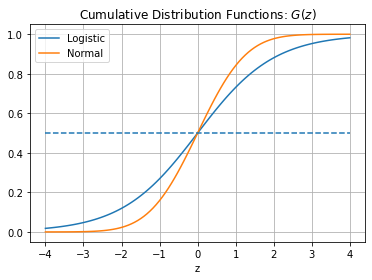

In [2]:
x = np.linspace(-4,4,100)
y_logistic = logistic.cdf(x)
y_norm = norm.cdf(x)
plt.plot(x, y_logistic,label='Logistic')
plt.plot(x, y_norm, label='Normal')
plt.hlines(y=0.5,xmin=-4,xmax=4,linestyles='--')
plt.xlabel('z')
plt.title(r'Cumulative Distribution Functions: $G(z)$')
plt.legend()
plt.grid()
pass

---
（コメント）
* (式１)に使うデータ
    * 左辺の被説明変数：$y=\{0,1\}$
    * 右辺の説明変数：$x$は通常の変数
* (式１)を最尤法（Maximum Likelihood Estimate; MLE）を使って非線形推定
    * 推定には`statsmodels`を使う。
    * (式１)の推計に基づく予測値 ＝ $x$を所与とする労働市場に参加する確率
* OLS推定では検定に$t$・$F$検定を使ったが，その代わりに最尤法のもとでの検定には３つある
    * Wald検定
    * 尤度比検定（Likelihood Ratio Test）
    * LM（Lagrange Multiperlier）検定（Score検定とも呼ばれる）
    * （大標本のもとで同じとなる; 使いやすいものを選択）

（注意１）
* 「理想的な」仮定のもとで，最尤推定量は
    * 一致性を満たす
    * 漸近的に（大標本）**正規分布**に従う
    * 漸近的に（大標本）効率的である
* 最尤推定量が一致性を満たさない要因に以下を含む（Green, 5th ed, p.679）
    * 誤差項のの不均一分散
    * 内生的説明変数
    * 欠落変数（右辺にある説明変数と相関しなくてもバイアスが発生する）

＜＜不均一分散が疑われる場合の問題＞＞
* OLS推定（復習であり，ここでは使わない）
    * 推定量は不偏性・一致性を満たす
    * 標準誤差は一致性を失う
        * 不均一分散頑健標準誤差を使うことにより，有効な検定を行うことが可能（即ち，推定量は一致性を満たしているので，標準誤差を修正することにより有効な検定となる）
* ML推定
    * 推定量は**一致性を満たさない**
    * 標準誤差も一致性を満たさない
        * 不均一分散頑健標準誤差を使うことが推奨されることがあるが（研究論文でもそうする研究者も多い）。しかし，係数の推定量は一致性を満たさないままなので，標準誤差だけを修正してもどこまで意味があるのか疑問である。即ち，この場合の不均一分散頑健標準誤差の有用性に疑問が残る（[参照](https://davegiles.blogspot.com/2013/05/robust-standard-errors-for-nonlinear.html)）。**このことは次章の制限従属変数モデルに当てはまるので注意すること。**
* 不均一分散に関しての対処方法
    * 均一分散の下での標準誤差と不均一分散頑健標準誤差に大きな差がなければ，不均一分散の問題は「大きくない」と考える。ただし目安。
    * 不均一分散の検定をおこなう。

## 推定

### データ

以下では，`mroz`のデータを使って女性の労働市場参加について考える。

In [3]:
mroz = wooldridge.data('mroz')
wooldridge.data('mroz', description=True)

name of dataset: mroz
no of variables: 22
no of observations: 753

+----------+---------------------------------+
| variable | label                           |
+----------+---------------------------------+
| inlf     | =1 if in lab frce, 1975         |
| hours    | hours worked, 1975              |
| kidslt6  | # kids < 6 years                |
| kidsge6  | # kids 6-18                     |
| age      | woman's age in yrs              |
| educ     | years of schooling              |
| wage     | est. wage from earn, hrs        |
| repwage  | rep. wage at interview in 1976  |
| hushrs   | hours worked by husband, 1975   |
| husage   | husband's age                   |
| huseduc  | husband's years of schooling    |
| huswage  | husband's hourly wage, 1975     |
| faminc   | family income, 1975             |
| mtr      | fed. marg. tax rte facing woman |
| motheduc | mother's years of schooling     |
| fatheduc | father's years of schooling     |
| unem     | unem. rate in county of res

* 被説明変数
    * `inlf`：1975年に労働市場に参加した場合１，しない場合は０
* 説明変数
    * `nwifeinc`：(`faminc` - `wage`*`hours`)/1000
        * `faminc`：1975年の世帯所得
        * `wage`：賃金
        * `hours`：就業時間
    * `educ`：教育年数
    * `exper`：労働市場参加期間
    * `expersq`：`exper`の２乗
    * `age`：女性の年齢
    * `kidslt6`：6歳未満の子供の数
    * `kidsge6`：6〜18さいの子供の数

### Logitモデル

回帰式の設定

In [4]:
formula = 'inlf ~ nwifeinc + educ + exper + expersq + age + kidslt6 + kidsge6'

推定の計算には`statsmodels`の`logit`関数を使う。使い方は`statsmodels`の`ols`と同じである。

In [5]:
res_logit = logit(formula, data=mroz).fit()

Optimization terminated successfully.
         Current function value: 0.533553
         Iterations 6


結果の表示

In [6]:
print(res_logit.summary())

                           Logit Regression Results                           
Dep. Variable:                   inlf   No. Observations:                  753
Model:                          Logit   Df Residuals:                      745
Method:                           MLE   Df Model:                            7
Date:                Sun, 08 May 2022   Pseudo R-squ.:                  0.2197
Time:                        17:33:19   Log-Likelihood:                -401.77
converged:                       True   LL-Null:                       -514.87
Covariance Type:            nonrobust   LLR p-value:                 3.159e-45
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4255      0.860      0.494      0.621      -1.261       2.112
nwifeinc      -0.0213      0.008     -2.535      0.011      -0.038      -0.005
educ           0.2212      0.043      5.091      0.0

`dir()`や`see()`を使うと，推定結果の属性やメソッドを確認できる。

In [7]:
see(res_logit)

    <                  <=                 ==                 !=
    >                  >=                 dir()              hash()
    help()             repr()             str()              .aic
    .bic               .bse               .conf_int()        .cov_kwds
    .cov_params()      .cov_type          .df_model          .df_resid
    .f_test()          .fittedvalues      .get_margeff()     .initialize()
    .k_constant        .llf               .llnull            .llr
    .llr_pvalue        .load()            .mle_retvals       .mle_settings
    .model             .nobs              .normalized_cov_params
    .params            .pred_table()      .predict()         .prsquared
    .pvalues           .remove_data()     .resid_dev
    .resid_generalized                    .resid_pearson     .resid_response
    .save()            .scale             .set_null_options()
    .summary()         .summary2()        .t_test()
    .t_test_pairwise()                    .tvalues           .u

例えば，`bse`は係数の標準誤差の属性である。

---
不均一分散について考察する。誤差項の分散が均一か不均一かを考える上で，２つの方法を説明する。

1. 不均一分散頑健標準誤差を使う場合と使わない場合の標準誤差を比べる。
    * 違いが小さければ，均一分散の可能性が高い。
    * しかし，これは１つの目安である。
1. 検定を用いる
    * 考え方：不均一分散の仮定の下で最尤推定し，均一分散と比較する。

---
方法１を考えよう。

In [8]:
# 上で推定した係数の標準誤差。
l0=res_logit.bse

# 不均一分散頑健標準誤差
l1=logit(formula, data=mroz).fit(cov_type='HC1',disp=False).bse

# `HC1`を使うことによる標準誤差の変化率（％）
100*(l1-l0)/l0

Intercept   -0.140629
nwifeinc     7.726361
educ         2.259971
exper        0.664423
expersq     -0.427766
age         -0.983628
kidslt6     -0.274232
kidsge6      6.738482
dtype: float64

大きく違っているようにもみえない。

次に方法２である検定をおこなう。まず`py4etrics`パッケージにある`hetero_test`モジュールを読み込み，その中に`het_test_logit()`という関数をつかう。

````{note}
MacではTerminal、WindowsではGit Bashを使い、次のコマンドで`py4etrics`モジュールをインストールできる。
```
pip install git+https://github.com/spring-haru/py4etrics.git
```
````

引数に推定結果のインスタンスを指定することにより，不均一分散のWald検定をおこなうことができる。

In [9]:
het_test_logit(res_logit)

H0: homoscedasticity
HA: heteroscedasticity
 
Wald test: 9.547 
p-value:   0.216 
df freedom:  7.


/Users/tetsu/opt/anaconda3/envs/jb/lib/python3.9/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


10%の有意水準でも均一分散の帰無仮説を棄却できない。

### Probitモデル

推定の計算には`statsmodels`の`probit`関数を使う。使い方は`logit`と同じである。上と同じデータと同じ`formula`を使う。

In [10]:
res_probit = probit(formula, data=mroz).fit()

Optimization terminated successfully.
         Current function value: 0.532938
         Iterations 5


In [11]:
print(res_probit.summary())

                          Probit Regression Results                           
Dep. Variable:                   inlf   No. Observations:                  753
Model:                         Probit   Df Residuals:                      745
Method:                           MLE   Df Model:                            7
Date:                Sun, 08 May 2022   Pseudo R-squ.:                  0.2206
Time:                        17:33:19   Log-Likelihood:                -401.30
converged:                       True   LL-Null:                       -514.87
Covariance Type:            nonrobust   LLR p-value:                 2.009e-45
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2701      0.509      0.531      0.595      -0.727       1.267
nwifeinc      -0.0120      0.005     -2.484      0.013      -0.022      -0.003
educ           0.1309      0.025      5.183      0.0

`dir()`や`see()`を使うと，推定結果の属性やメソッドを確認できる。

In [12]:
see(res_probit)

    <                  <=                 ==                 !=
    >                  >=                 dir()              hash()
    help()             repr()             str()              .aic
    .bic               .bse               .conf_int()        .cov_kwds
    .cov_params()      .cov_type          .df_model          .df_resid
    .f_test()          .fittedvalues      .get_margeff()     .initialize()
    .k_constant        .llf               .llnull            .llr
    .llr_pvalue        .load()            .mle_retvals       .mle_settings
    .model             .nobs              .normalized_cov_params
    .params            .pred_table()      .predict()         .prsquared
    .pvalues           .remove_data()     .resid_dev
    .resid_generalized                    .resid_pearson     .resid_response
    .save()            .scale             .set_null_options()
    .summary()         .summary2()        .t_test()
    .t_test_pairwise()                    .tvalues           .u

---
不均一分散について考察する。

In [13]:
# 上で推定した係数の標準誤差。
p0=res_probit.bse

# 不均一分散頑健標準誤差
p1=probit(formula, data=mroz).fit(cov_type='HC1',disp=False).bse

# `HC1`を使うことによる標準誤差の変化率（％）
100*(p1-p0)/p0

Intercept   -0.738030
nwifeinc     9.653354
educ         2.169440
exper        0.666688
expersq      0.055315
age         -1.528876
kidslt6     -2.021420
kidsge6      4.114557
dtype: float64

大きく違っているようにはみえない。

次に検定をおこなう。`py4etrics`パッケージの`hetero_test`モジュールにある`het_test_probit()`という関数を使う。使い方は`het_test_probit()`とおなじである。

In [14]:
het_test_probit(res_probit)

H0: homoscedasticity
HA: heteroscedasticity
 
Wald test: 8.665 
p-value:   0.278 
df freedom:  7.


/Users/tetsu/opt/anaconda3/envs/jb/lib/python3.9/site-packages/statsmodels/base/model.py:1889: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


10%の有意水準でも均一分散の帰無仮説を棄却できない。

## 係数の推定値の解釈

まず，`logit`と`probit`の結果を比べてわかるのは，係数の推定値は非常に似ているという点である。では，係数をどのように解釈できるのか考える。

＜通常のOLSの場合＞

推定式が

$$
\hat{y}=\hat{\beta}_0+\hat{\beta}_1x
$$

の場合，$\hat{\beta}_1$の解釈は簡単である。$\dfrac{\partial\hat{y}}{\partial x}=\hat{\beta}_1$となるので，（他の変数を一定にしたまま）$x$を一単位変化させた場合の$\hat{y}$に対する限界効果である。その限界効果は$x$に依存せず一定である。

---
＜Logit・Probitモデルの場合＞

$G(.)$の関数があるため，少し違ってくる。(式１)を微分すると次の結果を得る。

$$
\dfrac{\partial\hat{y}}{\partial x}=
\hat{\beta}_1\cdot g\left(\hat{\beta}_0+\hat{\beta}_1x\right), \qquad g(z)=\frac{dG(z)}{dz}
$$

重要な点は，$g\left(\hat{\beta}_0+\hat{\beta}_1 x\right)$は$x$に依存しているため，$x$が一単位変化した場合の限界効果は$x$の値に依存しているということである。限界効果を評価したい場合，$x$に何かの値を代入することにより評価する。ではどの値を使えば良いのか。２つの方法考える。

* Partial Effects at Average（平均での限界効果）：平均である$\bar{x}$で評価する。
    
    $$
    \text{PEA}=
    \hat{\beta}_1\cdot g\left(\hat{\beta}_0+\hat{\beta}_1\bar{x}\right)
    $$

* Average Partial Effects（平均限界効果）：全ての$x$値で評価した限界効果の平均
        
    $$
    \text{APE}=\dfrac{1}{n}\sum_{i=1}^n
    \hat{\beta}_1\cdot g\left(\hat{\beta}_0+\hat{\beta}_1\hat{x}\right)
    $$

（解釈）

$x$が１単位増加すると労働市場参加の確率（$P(y=1|x)=G(\beta_0+\beta_1x)$）はどれだけ変化するかを示す。

---
`statsmodels`では，推定結果（上の例では，`res_logit`と`res_probit`）のメソッド`get_margeff()`を使うことにより自動的に計算してくれる。デフォルトではAPEを返す。PEAには次の引数を使う。
* PEA：`at='mean'`
* APE：`at='overall'`（デフォルト）

また，`get_margeff()`は計算するだけなので，メソッド`summary()`を使って結果を表示する。

In [15]:
print(res_logit.get_margeff().summary())
print(res_logit.get_margeff(at='mean').summary())

        Logit Marginal Effects       
Dep. Variable:                   inlf
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
nwifeinc      -0.0038      0.001     -2.571      0.010      -0.007      -0.001
educ           0.0395      0.007      5.414      0.000       0.025       0.054
exper          0.0368      0.005      7.139      0.000       0.027       0.047
expersq       -0.0006      0.000     -3.176      0.001      -0.001      -0.000
age           -0.0157      0.002     -6.603      0.000      -0.020      -0.011
kidslt6       -0.2578      0.032     -8.070      0.000      -0.320      -0.195
kidsge6        0.0107      0.013      0.805      0.421      -0.015       0.037
        Logit Marginal Effects       
Dep. Variable:                   inlf
Method:                          dydx
At:                    

In [16]:
print(res_probit.get_margeff().summary())
print(res_probit.get_margeff(at='mean').summary())

       Probit Marginal Effects       
Dep. Variable:                   inlf
Method:                          dydx
At:                           overall
                dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
nwifeinc      -0.0036      0.001     -2.509      0.012      -0.006      -0.001
educ           0.0394      0.007      5.452      0.000       0.025       0.054
exper          0.0371      0.005      7.200      0.000       0.027       0.047
expersq       -0.0006      0.000     -3.205      0.001      -0.001      -0.000
age           -0.0159      0.002     -6.739      0.000      -0.021      -0.011
kidslt6       -0.2612      0.032     -8.197      0.000      -0.324      -0.199
kidsge6        0.0108      0.013      0.829      0.407      -0.015       0.036
       Probit Marginal Effects       
Dep. Variable:                   inlf
Method:                          dydx
At:                    

APEとPEAの値だけを取り題したい場合は，属性`margeff`を使うと良いだろう。

In [17]:
res_probit.get_margeff(at='mean').margeff

array([-0.00469623,  0.05112871,  0.04817705, -0.00073705, -0.02064317,
       -0.33915138,  0.0140628 ])

## 推定結果の表（上段右）

推定結果の表を説明するために`logit`の結果を再度表示する。（`probit`も同じ項目が表示されている）

In [18]:
print(res_logit.summary().tables[0])

                           Logit Regression Results                           
Dep. Variable:                   inlf   No. Observations:                  753
Model:                          Logit   Df Residuals:                      745
Method:                           MLE   Df Model:                            7
Date:                Sun, 08 May 2022   Pseudo R-squ.:                  0.2197
Time:                        17:33:19   Log-Likelihood:                -401.77
converged:                       True   LL-Null:                       -514.87
Covariance Type:            nonrobust   LLR p-value:                 3.159e-45


* `No. Observations`：観測値の数（データの大きさ）
    * 属性`nobs`
* `DF Residuals`：定数以外の係数の数
    * 属性`df_resid`
* `DF Model`：定数以外の係数の数
    * 属性`df_model`
* `Pseudo R-squ`（疑似決定係数）：
    * MLEはOLSではないため$R^2$はない。その代わりになる指標がPseudo $R^2$（疑似決定係数）といわれるものであり，その１つが表にあるMcFaddenが考案した Pseudo $R^2$。
    * 属性`prsquared`
* `Log-Likelihood`（残差の対数尤度）
    * 大きいほど当てはまり良い
    * 属性`llf`
* `LL-Null`（定数以外の係数を０に制限した場合の残差の対数尤度）
    * 属性`llnull`
* `LLR p-value`：
    * 定数項（Intercept）以外の係数が全て０であるという帰無仮説のもとでのp値。ここでは非常に小さな数字であり，帰無仮説を棄却できる。
    * 属性`llr_pvalue`

## 尤度比検定

尤度比検定（Likelihood Ratio Test）について説明する。検定量は，次式に従って制限を課す場合と課さない場合の残差の対数尤度を使って計算する。

$$LR=2\left(\cal{L}_{ur}-\cal{L}_{r}\right)$$


* $\cal{L}_{ur}$：制限がない場合の対数尤度
* $\cal{L}_{r}$：制限がある場合の対数尤度

$LR$は漸近的にカイ二乗分布に従う。

$$LR\sim \chi_q^2,\qquad q=\text{制限される係数の数}$$

### 例１

例として，Probit推定を考える。

$\text{H}_0$：定数項以外の係数は全て０

$\text{H}_A$：$\text{H}_0$は成立しない

In [19]:
ll_ur = res_probit.llf  # 制限を課さない場合の対数尤度

ll_r = res_probit.llnull  # 制限を課す場合の対数尤度

LR = 2*(ll_ur-ll_r)  # LR統計量

dof = res_probit.df_model  #  自由度＝制限を課すパラメータの数

1- chi2.cdf(LR, dof)

0.0

1%水準で帰無仮説は棄却できる。

この結果は推定結果の表にある`LLR p-value`と同じであり，`res_probit`の属性`.llr_pvalue`を使って直接表示することも可能である。

In [20]:
res_probit.llr_pvalue

2.0086732957629427e-45

### 例２

次に，Probit推定を考える。

$\text{H}_0$：`exper`，`expersq`，`age`の係数は０

$\text{H}_A$：$\text{H}_0$は成立しない

帰無仮説の下での推定をおこなう。

In [21]:
formula_0 = 'inlf ~ nwifeinc + educ + kidslt6 + kidsge6'

res_probit_0 = probit(formula_0, data=mroz).fit(cov_type='HC1')

Optimization terminated successfully.
         Current function value: 0.617290
         Iterations 5


In [22]:
ll_ur = res_probit.llf  # 制限を課さない場合の対数尤度

ll_r = res_probit_0.llf  # 制限を課す場合の対数尤度

LR = 2*(ll_ur-ll_r)  # LR統計量

dof = 3  #  自由度＝制限を課すパラメータの数

1- chi2.cdf(LR, dof)

0.0

1%水準で帰無仮説は棄却できる。

## 線形確率モデル

線形確率モデル（Linear Probability Model）を考えるために，関数$G(.)$に関して以下を仮定する。

$$
G(z) = z
$$

線形確率モデルの利点は，通常のOLS推定が可能だということである。しかし，誤差項は不均一分散となるため以下では不均一分散頑健標準誤差を使う。

In [23]:
res_lin = ols(formula, mroz).fit(cov_type='HC1')

print(res_lin.summary())

                            OLS Regression Results                            
Dep. Variable:                   inlf   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     62.48
Date:                Sun, 08 May 2022   Prob (F-statistic):           1.30e-70
Time:                        17:33:19   Log-Likelihood:                -423.89
No. Observations:                 753   AIC:                             863.8
Df Residuals:                     745   BIC:                             900.8
Df Model:                           7                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5855      0.152      3.846      0.0

この推定法の問題は，確率の予測値が$[0,1]$に収まらない場合があることである。この点については以下で確認する。

## ３つのモデルの比較

上述の３つのモデルの推定結果のメソッド`predict()`は

　　　労働参加の確率$P(y=1|x)$の予測値

を返す。

---
＜＜注意＞＞

* 推定結果には属性`fittedvalues`があるが，３つのモデルでは以下が返される。

    $$\hat{\beta}_0+\hat{\beta}_1x$$

* 解釈
    * 線形確率モデル：労働参加の確率$P(y=1|x)$の予測値（`predict()`と同じ）
    * Logit・Probitモデル：潜在変数（または効用）$y^*$の予測値

---
線形確率モデルでは，労働参加の確率は１以上もしくは０以下になり得る。

In [24]:
no_1 = (res_lin.fittedvalues>1).sum()

no_0 = (res_lin.fittedvalues<0).sum()

print(f'1を上回る予測値の数：{no_1}\n0を下回る予測値の数：{no_0}')

1を上回る予測値の数：17
0を下回る予測値の数：16


---
LogitモデルとProbitモデルの予測値を図を使って比べてみる。

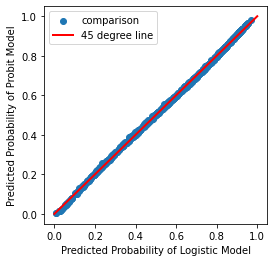

In [25]:
xx = np.linspace(0,1,100)

y_logit = res_logit.predict()
y_probit = res_probit.predict()

plt.figure(figsize=(4,4))  # 図のサイズ
plt.scatter(y_logit,y_probit, label='comparison')
plt.plot(xx, xx, color='red', linewidth = 2, label='45 degree line')
plt.xlabel('Predicted Probability of Logistic Model')
plt.ylabel('Predicted Probability of Probit Model')
plt.legend()
pass

LogitモデルとProbitモデルの予測確率は殆ど変わらない。ではLogitとProbitのどちらをどのような基準で選ぶべきか。*Microeconometrics Using Stata* (2009)は次を推奨している。
* 対数尤度（log likelihood）が高い方を選ぶ。

確認するために，それぞれの結果の属性`.llf`を比べる。

In [26]:
res_logit.llf, res_probit.llf

(-401.76515113438177, -401.30219317389515)

Probitの対数尤度が高いが，殆ど変わらない。この結果は上の図にも反映されている。